# Tutorial on the LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset. 


- LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `llm` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).
- The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm. . 

## Installation

```bash 
pip install lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

Dont forget to setup your LLM API key. 

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```



In [1]:
from lida import Manager, TextGenerationConfig , llm 
from lida.utils import plot_raster 

## Summarize Data, Generate Goals

In [2]:
lida = Manager(text_gen = llm("openai")) 
# lida = Manager(text_gen = llm(provider="hf", model="TheBloke/gpt4-x-vicuna-13B-HF", device_map="auto"))
# lida = Manager(text_gen = llm("openai")) 
# lida = Manager(text_gen = llm("cohere")) 
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="columns", textgen_config=textgen_config)  
goals = lida.goals(summary, n=1, textgen_config=textgen_config)
print(goals)

[Goal(index=0, question='What is the distribution of Retail_Price and Dealer_Cost?', visualization='side-by-side histogram of Retail_Price and Dealer_Cost', rationale='This visualization will allow us to compare the distribution of the retail price and dealer cost of the cars in the dataset. It will help us understand the pricing strategy of the car manufacturers and dealerships.')]


## Generate Visualizations

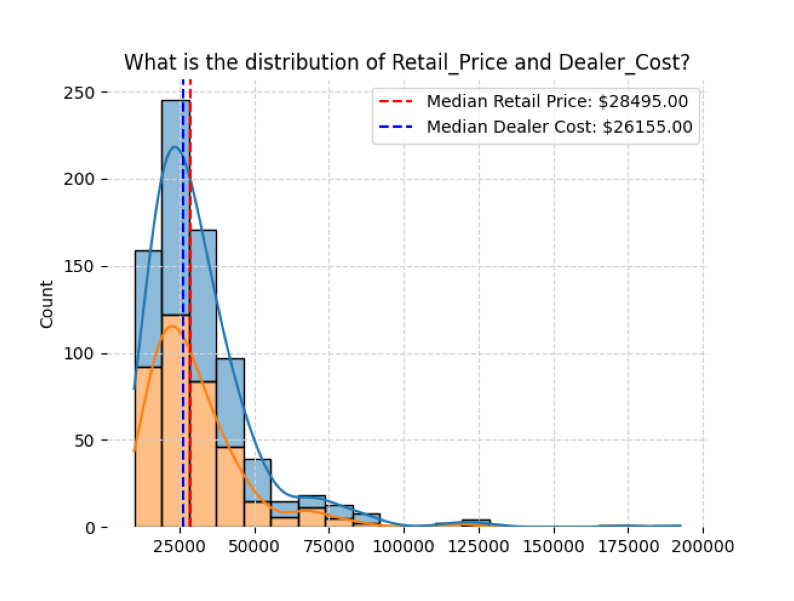

In [3]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library) 
# plot raster image of chart
plot_raster(charts[0].raster) 

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

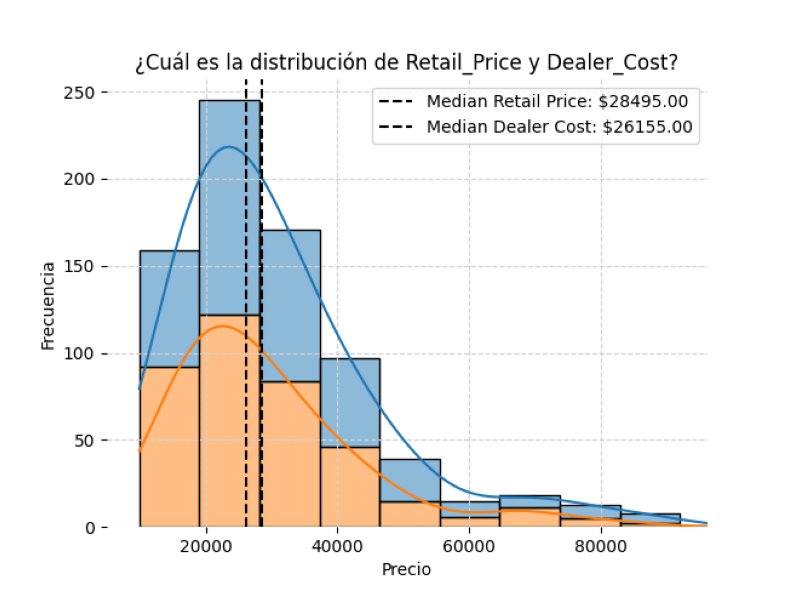

In [4]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["Zoom in by 50% ", "change the color of the chart to red", "translate the title to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)

plot_raster(edited_charts[0].raster)

## Visualization explanations and accessibility

In [5]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The code generates a side-by-side histogram of the Retail_Price and Dealer_Cost columns of a given pandas DataFrame. The goal of the chart is to visualize the distribution of the two columns and compare them. The chart also includes vertical lines for the median of each column to provide additional insights.
transformation  **  This line of code creates a new DataFrame called df that includes only the 'Retail_Price' and 'Dealer_Cost' columns from the original DataFrame.
visualization  **  This line of code creates a side-by-side histogram of the 'Retail_Price' and 'Dealer_Cost' columns using the seaborn.histplot() function. The 'data' parameter is set to the newly created df DataFrame, 'bins' is set to 20 to specify the number of bins in the histogram, 'alpha' is set to 0.5 to adjust the transparency of the bars, 'multiple' is set to 'stack' to stack the bars on top of each other, and 'kde' is set to True to add a kernel density estimate to the plot.
visualization  *

## Visualization code self-evaluation and repair

In [6]:
evaluations = lida.evaluate(code=code,  goal=goals[i], library=library)[0] 

In [7]:
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])

bugs Score 10 / 10
	 The code is free of bugs, syntax errors, or typos.
transformation Score 10 / 10
	 The data is appropriately transformed by selecting only the 'Retail_Price' and 'Dealer_Cost' columns from the original dataframe.
compliance Score 10 / 10
	 The code meets the specified goal of visualizing the distribution of 'Retail_Price' and 'Dealer_Cost'.
type Score 9 / 10
	 The histogram is an appropriate visualization type for showing the distribution of continuous variables. However, a box plot or violin plot may be more effective in showing the distribution and median
encoding Score 10 / 10
	 The data is encoded appropriately by plotting the two variables on the x-axis and the frequency on the y-axis.
aesthetics Score 10 / 10
	 The aesthetics of the visualization are appropriate for a histogram, with a clear title, legend, and color scheme.


## Visualization Recommendation

In [8]:
textgen_config = TextGenerationConfig(n=1, temperature=0.6, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

Recommended 2 charts
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



# solution plan
# i. create a new dataframe with Horsepower_HP_ and Retail_Price columns
# ii. plot a scatter plot of Horsepower_HP_ vs. Retail_Price


def plot(data: pd.DataFrame):
    
    # i. create a new dataframe with Horsepower_HP_ and Retail_Price columns
    df = data[['Horsepower_HP_', 'Retail_Price']]

    # ii. plot a scatter plot of Horsepower_HP_ vs. Retail_Price
    ax = sns.scatterplot(x='Horsepower_HP_', y='Retail_Price', data=df)
    plt.title('How does Horsepower relate to Retail_Price?', wrap=True)
    plt.xlabel('Horsepower')
    plt.ylabel('Retail_Price')
    
    return plt;

chart = plot(data) 



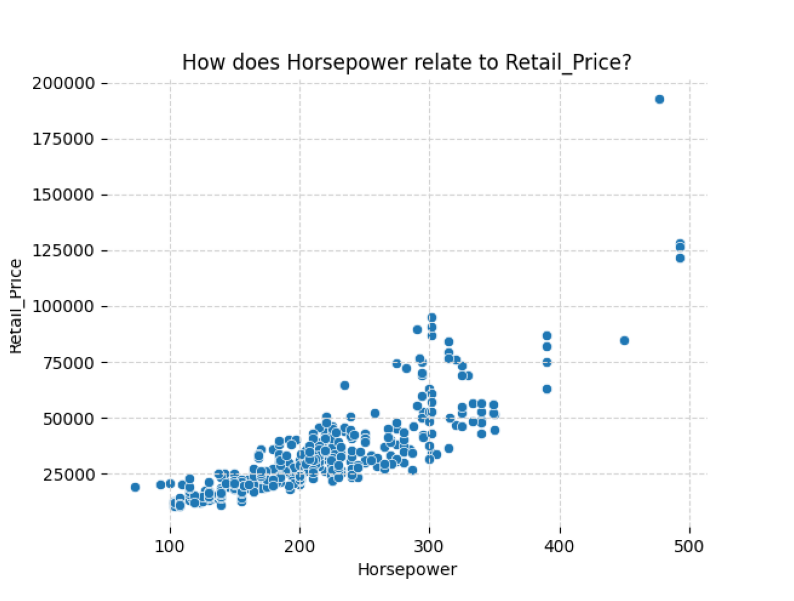

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



# solution plan
# i. create a new dataframe with AWD and Retail_Price columns
# ii. plot a violin plot of Retail_Price by AWD


def plot(data: pd.DataFrame):
    
    # i. create a new dataframe with AWD and Retail_Price columns
    df = data[['AWD', 'Retail_Price']]

    # ii. plot a violin plot of Retail_Price by AWD
    ax = sns.violinplot(x='AWD', y='Retail_Price', data=df)
    plt.title('How does AWD affect Retail_Price distribution?', wrap=True)
    plt.xlabel('AWD')
    plt.ylabel('Retail_Price')
    
    return plt;

chart = plot(data) 



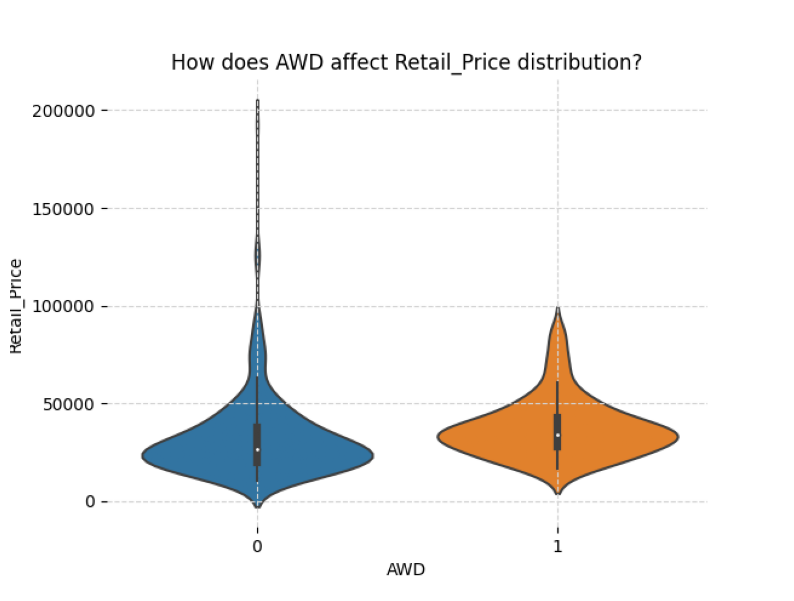

In [9]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    print(chart.code, "\n====================\n")  
    # plot raster image of chart
    plot_raster(chart.raster) 
    pass

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models

In [10]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, rain drops, highly detailed, no blur, white background")

/home/victordibia/miniconda3/envs/coral/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 27 files: 100%|██████████| 27/27 [00:00<00:00, 107648.49it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Resizing init_image to (512, 512).
100%|██████████| 31/31 [00:01<00:00, 16.62it/s]


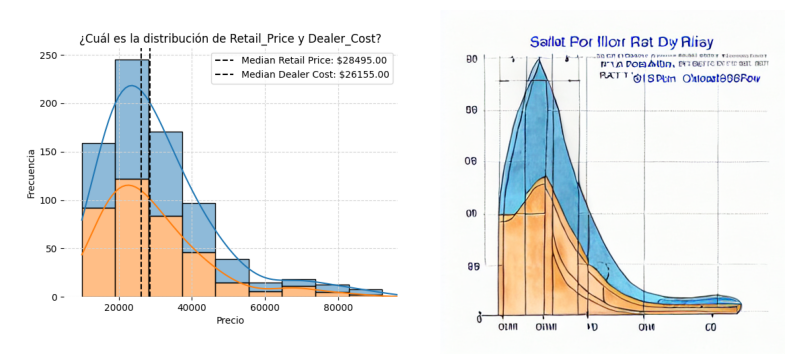

In [11]:
plot_raster([edited_charts[0].raster, infographics["images"][0]]) 